# Tree Parzen Estimator(TPE)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import tqdm, random
import os
# print(os.listdir())
import sys
sys.path.append('../../')
from base.testproblem.testfunction import Rastrigin
from base.kde.toy_kde import NaiveKDE

In [3]:
# 使用scikit-learn包中的 KernelDensity 类实现
class FloatVarKDE():
    def __init__(self, low=0, high=1, bandwidth=0.1):
        self.bandwidth = bandwidth
        # self.kde = NaiveKDE(bandwidth=bandwidth)
        self.kde = KernelDensity(bandwidth=bandwidth)
        self.low = low
        self.high = high
        # self.kde.fit(high-low)
    
    def sample(self, num):
        cnt = 0
        samples = []
        while cnt < num:
            sample = self.kde.sample().item()
            if self.low <= sample <= self.high:
                cnt += 1
                samples.append(sample)
        return np.asarray(samples)

    def fit(self, points):
        self.kde.fit(points.reshape(-1, 1))

    def log_pdf(self, x):
        return self.kde.score_samples(x.reshape(-1, 1))


class FloatNaiveKDE(NaiveKDE):
    def __init__(self, low=0, high=1, bandwidth=0.1):
        NaiveKDE.__init__(self, bandwidth=bandwidth)
        self.low = low
        self.high = high
        self.bandwidth = bandwidth
    
    def fit(self, x):
        NaiveKDE.fit(self, x)
    
    def log_pdf(self, x):
        return np.log(NaiveKDE.evaluate(self, x))
    
    def sample(self, num):
        ct = 0
        samples = []
        while ct < num:
            u = np.random.uniform(0, 1)
            idx = int(u * len(self.data))
            sample = np.random.normal(self.data[0, idx].item(), self.bandwidth)
            if self.low <= sample <= self.high:
                ct += 1
                samples.append(sample)

        return samples
        # u = np.random.random.uniform(0, 1, size=num)
        # idx = (u * len(self.data)).as_type(np.int64)
        # return np.random.normal(self.data[idx], self.bandwidth)


$$
E I_{y^{*}}(x)=\frac{\gamma y^{*} \ell(x)-\ell(x) \int_{-\infty}^{y^{*}} p(y) d y}{\gamma \ell(x)+(1-\gamma) g(x)} \propto\left(\gamma+\frac{g(x)}{\ell(x)}(1-\gamma)\right)^{-1}
$$

![](attachments/2021-08-11-16-05-01.png)

1. warnup一笔sample(随机采样等)
3. 将这笔sample按$\gamma$比例分成两类，`good`和`bad`
4. 对这笔sample的**每一个**样本为中心建一个Gaussian分布(*james rule*),称为为基（basis）
5. 每次随机从`good`Gaussian分布中sample一个candidate，直到满足一定的candidate数量
6. 分别计算这些candidates在`good`与`bad`的似然,取似然比值最大的一个candidate为本次suggest结果($argmax$ EI function)
7. evaluate刚得到的suggestion，更新sample集合，回到第二步

In [4]:
class ToyTPE():
    def __init__(self,
                 config,
                 cls=FloatVarKDE,
                 bandwidth=1,
                 min_sample=30,
                 gamma=0.1,
                 candidates_num=24):
        self.gamma = gamma
        self.min_sample = min_sample
        self.bandwidth = bandwidth
        self.candidates_num = candidates_num
        self.hp_num = len(config)
        self.hp_range = []
        self.hp_names = list(sorted(config.keys()))
        for name in self.hp_names:
            self.hp_range.append(config[name])
        self.lx = [cls(*lh, bandwidth=bandwidth) for lh in (self.hp_range)]
        self.gx = [cls(*lh, bandwidth=bandwidth) for lh in (self.hp_range)]
        # self.lx = [FloatNaiveKDE(*lh) for lh in (self.hp_range)]
        # self.gx = [FloatNaiveKDE(*lh) for lh in (self.hp_range)]
        self.history = []
        self.history_y = []

    def suggest(self, ):
        # 只suggest 一个
        if len(self.history_y) <= self.min_sample or np.random.rand() < 0.1:
            return self._random_suggest()
        else:
            suggest_array = []
            for i in range(self.hp_num):
                candidates = self.lx[i].sample(self.candidates_num)
                lx = self.lx[i].log_pdf(candidates)
                gx = self.gx[i].log_pdf(candidates)
                max_idx = np.argmax(lx - gx)
                suggest_array.append(candidates[max_idx])
            return {k: suggest_array[i] for i, k in enumerate(self.hp_names)}

    def _random_suggest(self):
        suggest_array = []
        for i in range(self.hp_num):
            suggest_array.append((np.random.rand() *
                                  (self.hp_range[i][1] - self.hp_range[i][0]) +
                                  self.hp_range[i][0]))
        return {k: suggest_array[i] for i, k in enumerate(self.hp_names)}

    def _split_l_g(self):
        samples = np.asarray(self.history)
        good_num = int(self.gamma * len(samples))
        samples_sorted = samples[np.argsort(self.history_y)]
        good_points = samples_sorted[:good_num, :]
        bad_points = samples_sorted[good_num:, :]
        return good_points, bad_points

    def observe(self, x, y):
        sample_array = []
        for k in self.hp_names:
            sample_array.append(x[k])
        self.history.append(sample_array)
        self.history_y.append(y)
        if len(self.history_y) < self.min_sample:
            return

        good_points, bad_points = self._split_l_g()
        for i in range(self.hp_num):
            self.lx[i].fit(good_points[:, i])
            self.gx[i].fit(bad_points[:, i])


100%|██████████| 100/100 [00:00<00:00, 339.47it/s]


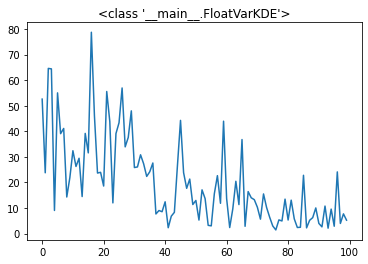

1.4343788301755627


100%|██████████| 100/100 [00:00<00:00, 2727.74it/s]


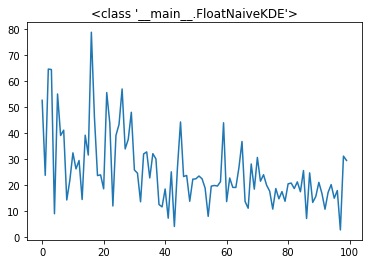

2.805671960962986


In [5]:

def tpe_test(cls):
    np.random.seed(42)
    random.seed(42)
    
    func = Rastrigin(dim=2)
    opt = ToyTPE(config=func._load_api_config(), cls=cls)
    for iter in tqdm.tqdm(range(100)):
        x = opt.suggest()
        y = func(x)
        opt.observe(x, y)
    plt.figure()
    plt.plot(opt.history_y)
    plt.title(str(cls))
    plt.show()
    print(min(opt.history_y))
tpe_test(FloatVarKDE)
tpe_test(FloatNaiveKDE)

100%|██████████| 100/100 [00:00<00:00, 1663.55it/s]


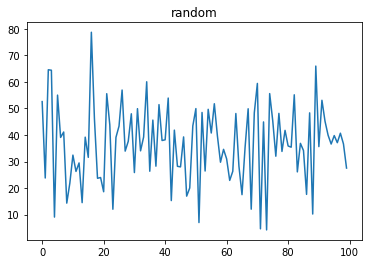

4.201927272996498


In [6]:
def random_test():
    np.random.seed(42)
    random.seed(42)
    
    func = Rastrigin(dim=2)
    opt = ToyTPE(config=func._load_api_config())
    for iter in tqdm.tqdm(range(100)):
        x = opt._random_suggest()
        y = func(x)
        opt.observe(x, y)
    plt.figure()
    plt.plot(opt.history_y)
    plt.title(str('random'))
    plt.show()
    print(min(opt.history_y))
random_test()